In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [13]:
# this needs a settings.cfg file in the same directory

import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1


dir_ip21 = ConfigSectionMap("SectionOne")['ip21']
dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_alarms = ConfigSectionMap("SectionOne")['alarms']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_alarms is %s" % (dir_alarms))

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_alarms is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/Alarms_data/


In [14]:
def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]


In [15]:
filename = 'alarms.csv'
path = os.path.join(dir_ip21, filename)
# parse_dates and index datafram
df = pd.read_csv(path, encoding='UTF-8', parse_dates=True, index_col='Start')
df.sort_index(inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# df = pd.read_csv(r'C:\Users\Raza-PC\Documents\McLaren\Sanofi\Sanofi\alarms.csv')

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 727905 entries, 2020-12-28 10:25:23 to 2021-08-17 18:58:42
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Message Text (English)  727905 non-null  object 
 1   Message Text            727905 non-null  object 
 2   Duration                443872 non-null  float64
 3   Filename                727905 non-null  object 
 4   Machine                 727905 non-null  object 
dtypes: float64(1), object(4)
memory usage: 49.4+ MB


In [17]:
#Define start and end date for specified time period, number of days is calculated.

start_date = '2021-04-01'
end_date = '2021-08-01'

days = datetime.strptime(end_date, '%Y-%m-%d')-datetime.strptime(start_date, '%Y-%m-%d')
# think this needs to be +1 day now that date filter is inclusive of end_date
ndays=days.days+1

# df_dates=df[(df['Start'] >= start_date) & (df['Start'] <= end_date) ]
df_dates = df.loc[start_date:end_date]


# df_dates=df_dates[df_dates['Filename'].str.contains(machine)]

In [28]:
writer = pd.ExcelWriter(dir_ip21 + 'Alarms_Reader_Messages.xlsx', engine='xlsxwriter')
for temp_machine in df_dates.Machine.unique():
    temp_df = df_dates[df_dates.Machine.str.contains(temp_machine)]
    grouped = temp_df[['Machine', 'Message Text (English)','Duration']].groupby(['Message Text (English)']).agg({'Duration':'sum', 'Message Text (English)': 'count'})
    # convert Duration secs to mins
    grouped['Duration'] = round (grouped['Duration'] / 60, 0)
    grouped.rename(columns={'Duration':'Duration (mins)'}, inplace=True)
    grouped.rename(columns={'Message Text (English)':'count'}, inplace=True)
    # grouped.nlargest(25, 'Duration')
    grouped.sort_values(by=(['Duration (mins)', 'count']), ascending=False, inplace=True)
    grouped = grouped.nlargest(25, 'Duration (mins)')
    grouped.to_excel(writer, sheet_name=temp_machine)
    # call function get_col_widths to auto size the excel columns
    workbook = writer.book
    worksheet = writer.sheets[temp_machine]
    for x, width in enumerate(get_col_widths(grouped)):
        #set each column width to be 1*25 that of the max string so that it fits nicely
        worksheet.set_column(x, x, width * 1.3)    



df_dates.sort_values(by=['Duration'], ascending=False).reset_index(inplace=True)
df_dates.to_excel(writer, sheet_name='all_messages')
workbook = writer.book
worksheet = writer.sheets['all_messages']
for x, width in enumerate(get_col_widths(grouped)):
    #set each column width to be 1*25 that of the max string so that it fits nicely
    worksheet.set_column(x, x, width * 1.3)    
writer.save()

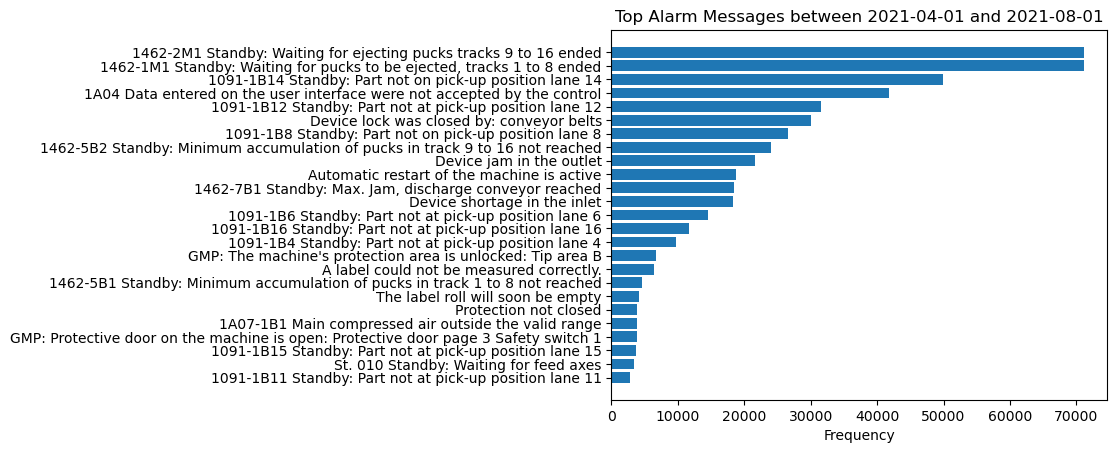

In [21]:
s=df_dates['Message Text (English)'].value_counts()
#Show top 25 alert messages
top=s.nlargest(25)
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
names = (top.index)
y_pos = np.arange(len(names))
performance= top.values

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Frequency')
ax.set_title('Top Alarm Messages between {} and {}'.format(start_date, end_date))

plt.show()

In [22]:
#Group data by alert message and calculate mean duration and frequency. Convert duration to minutes.
m=df_dates.groupby('Message Text (English)').agg(['mean', 'count'])
mc = m['Duration']['mean'] * m['Duration']['count'] / (60*ndays)

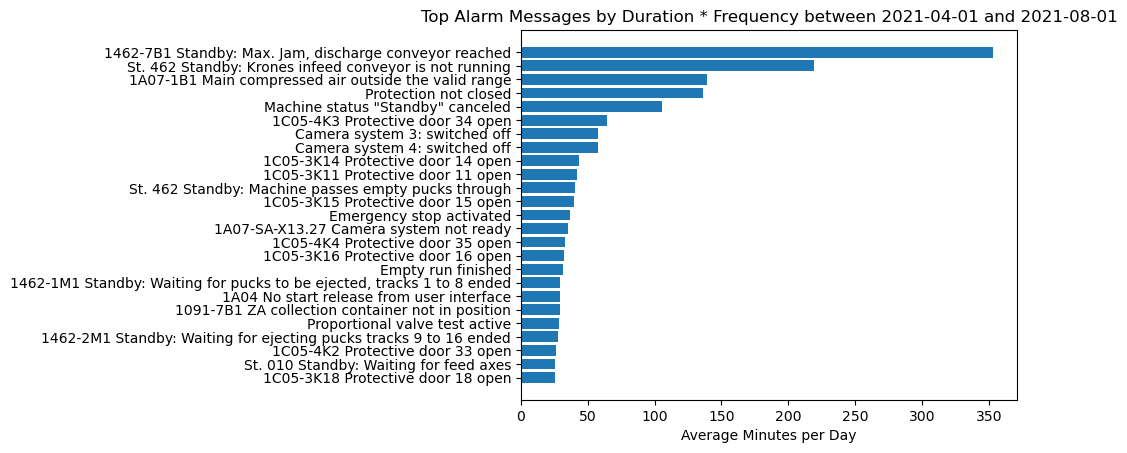

In [23]:
#Plot top 25 most significant error messages.
top=mc.nlargest(25)
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
names = (top.index)
y_pos = np.arange(len(names))
performance= top.values

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Minutes per Day')
ax.set_title('Top Alarm Messages by Duration * Frequency between {} and {}'.format(start_date, end_date))

plt.show()

In [150]:
df_dates.sort_values(by=['Duration'], ascending=False).reset_index(inplace=True)

Machine  \
                        
0    AL6_Etikettierer   
1    AL6_Etikettierer   
2    AL6_Etikettierer   
3    AL6_Etikettierer   
4    AL6_Etikettierer   
..                ...   
266  AL6_Etikettierer   
267  AL6_Etikettierer   
268  AL6_Etikettierer   
269  AL6_Etikettierer   
270  AL6_Etikettierer   

                                             Message Text (English) Duration  \
                                                                         sum   
0                                                01-01 Solostar PEN      0.0   
1                                         03-01 Toujeo Solostar PEN      0.0   
2                                   24V fuse has tripped: dispenser      0.0   
3                                        24V fuse has tripped: reel      0.0   
4                          A label could not be measured correctly.      0.0   
..                                                              ...      ...   
266           User 'PU109912 - Schleich, Manuel / DE PAM' logged in      0.0   
267        User 'PU109914 - Jung-Koenig, Tobias / DE PAM' logged in      0.0   
268  User 'PU111181 - Trzuskowski, Jacek Gregor / DE PAM' logged in      0.0   
269           User 'PU111183 - Forster, Florian / DE PAM' logged in      0.0   
270            User 'PU119966 - Schwab, Hermann / DE PAM' logged in      0.0   

           
    count  
0       0  
1       0  
2       0  
3       0  
4       0  
..    ...  
266     0  
267     0  
268     0  
269     0  
270     0  

[271 rows x 4 columns]

In [30]:
m

Duration  \
                                                                                                         mean   
Message Text (English)                                                                                          
01-01 Solostar PEN                                                                                        NaN   
03-01 Toujeo Solostar PEN                                                                                 NaN   
1001-1M1 Camshaft position not valid. Please read off the indicator disc and enter it on the HMI    34.666667   
1002-1M1 Camshaft position not valid. Please read off the indicator disc and enter it on the HMI    34.666667   
1005-2B1 bad parts container full                                                                   17.764706   
...                                                                                                       ...   
User 'PU109914 - Jung-Koenig, Tobias / DE PAM' logged in                                                  NaN   
User 'PU111181 - Trzuskowski, Jacek Gregor / DE PAM' logged in                                            NaN   
User 'PU111183 - Forster, Florian / DE PAM' logged in                                                     NaN   
User 'PU119966 - Schwab, Hermann / DE PAM' logged in                                                      NaN   
xxx - parts of the order size reached                                                             1356.451613   

                                                                                                        
                                                                                                 count  
Message Text (English)                                                                                  
01-01 Solostar PEN                                                                                   0  
03-01 Toujeo Solostar PEN                                                                            0  
1001-1M1 Camshaft position not valid. Please read off the indicator disc and enter it on the HMI     6  
1002-1M1 Camshaft position not valid. Please read off the indicator disc and enter it on the HMI     6  
1005-2B1 bad parts container full                                                                   17  
...                                                                                                ...  
User 'PU109914 - Jung-Koenig, Tobias / DE PAM' logged in                                             0  
User 'PU111181 - Trzuskowski, Jacek Gregor / DE PAM' logged in                                       0  
User 'PU111183 - Forster, Florian / DE PAM' logged in                                                0  
User 'PU119966 - Schwab, Hermann / DE PAM' logged in                                                 0  
xxx - parts of the order size reached                                                               62  

[779 rows x 2 columns]

Text(0.5, 1.0, 'Count of roll alerts for Etikettierer')

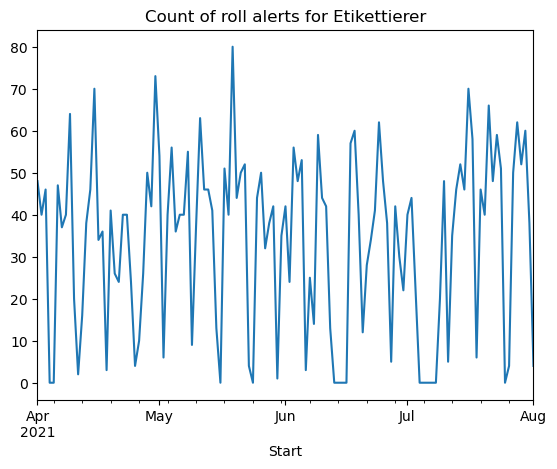

In [147]:
df_label = df_dates[df_dates['Message Text (English)'].str.contains('The label roll will soon be empty')]
df_label.groupby(pd.Grouper(freq='D'))['Machine'].count().plot()
plt.title('Count of roll alerts for Etikettierer')

In [146]:
df_label

,Message Text (English),Message Text,Duration,Filename,Machine
Start,,,,,
2021-04-01 00:04:28,The label roll will soon be empty,Die Etikettenrolle ist bald leer,NaN,AL6Audit Trail 000000 2021-04-01 K747B14.csv,AL6_Etikettierer
2021-04-01 00:22:00,The label roll will soon be empty,Die Etikettenrolle ist bald leer,NaN,AL6Audit Trail 000000 2021-04-01 K747B14.csv,AL6_Etikettierer
2021-04-01 02:40:06,The label roll will soon be empty,Die Etikettenrolle ist bald leer,NaN,AL6Audit Trail 030000 2021-04-01 K747B14.csv,AL6_Etikettierer
2021-04-01 02:40:29,The label roll will soon be empty,Die Etikettenrolle ist bald leer,NaN,AL6Audit Trail 030000 2021-04-01 K747B14.csv,AL6_Etikettierer
2021-04-01 02:41:10,The label roll will soon be empty,Die Etikettenrolle ist bald leer,NaN,AL6Audit Trail 030000 2021-04-01 K747B14.csv,AL6_Etikettierer
...,...,...,...,...,...
2021-07-31 23:55:39,The label roll will soon be empty,Die Etikettenrolle ist bald leer,NaN,AL6Audit Trail 000000 2021-08-01 K747B14.csv,AL6_Etikettierer
2021-08-01 00:45:24,The label roll will soon be empty,Die Etikettenrolle ist bald leer,NaN,AL6Audit Trail 000000 2021-08-01 K747B14.csv,AL6_Etikettierer
2021-08-01 00:46:34,The label roll will soon be empty,Die Etikettenrolle ist bald leer,NaN,AL6Audit Trail 000000 2021-08-01 K747B14.csv,AL6_Etikettierer
